In [39]:
import random
import math
import matplotlib.pyplot as plt
import copy
import heapq
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import time

In [40]:
N = 6  # num of vertex
M = 10  # network radius
R = 2  # neighbors radius
K = 1  # num of channels
F = 10  # number of flows
FLOW_MAX_DATA = 1000
calc_inter_face = False

CONSTANT_POWER = 1
CONSTANT_BW = 1
down_Ri = 41e5
K_B = 1.38e-23  # Boltzmann constant in Joules/Kelvin
T = 290       # Temperature in Kelvin


def set_global_params(k=None, n=None, m=None, r=None, f=None):
    global K, N, M, R, F
    K = k or 1
    N = n or 5
    M = m or 10
    R = r or 2
    F = f or 10

<h2>fundamental function

In [41]:
def PrintRateResults(xAxis, yAxis, users, alpha, Algorithm):
    plt.figure()
    print(f"-------------------------")
    print(f"{Algorithm} Algorithm, alpha={str(alpha)} Results:")
    sum_rate = 0
    for user in users:
        sum_rate += user.rate
        print(f"user {user.Uid} rate : {round(user.rate,2)}")
    print(f"sum_rate={round(sum_rate,2)}\n")
    for i in range(len(xAxis)):
        plt.plot(xAxis[i], yAxis[i], label=f"user {i+1}")
    plt.title(f"{Algorithm} Algorithm, alpha={str(alpha)}")
    plt.xlabel("Iteration Number")
    plt.ylabel("Rate")
    plt.legend()
    plt.grid()
    plt.show(block=False)

In [42]:
def CalcDualRate(user, users, alpha, x_r, stepSize=0.0001):
    """ this function calculates the next rate of a given user for the dual algorithm """

    if alpha == float("inf"):
        # Adjusting based on the max constraint violation
        max_excess = max((sum(u.rate for u in users if link in u.links) - link.total_capacity) for link in user.links)
        return max(0, min(1, x_r - stepSize * max_excess))

    Q_l = 0
    for link in user.links:  # calculate the payment of the user
        rateSum = sum(u.rate for u in users if link in u.links) # Y_l
        L_delta = (rateSum - link.total_capacity) * stepSize
        link.LagrangianMultiplier = max(0, link.LagrangianMultiplier + L_delta)
        Q_l += link.LagrangianMultiplier
    if Q_l == 0:
        print("Ql is zero!")
    return pow(Q_l, -1/alpha) if Q_l != 0 else 0 # the inverse function of the utilization function



In [43]:
def penaltyFunction(rate, capacity):
    if rate < capacity:
        return rate * capacity
    else:
        try:
            return pow(rate, 3) * 2
        except OverflowError: # TODO: check why it is overflow error
            return 0


In [44]:
def CalcPrimalRate(user, users, alpha, x_r, stepSize=0.0001):
    if alpha == float("inf"):
        avg_rate = sum(u.rate for u in users) / len(users)
        return max(0, min(1, avg_rate + stepSize)) if user.rate < avg_rate else max(0, user.rate - stepSize)

    payment = 0
    for link in user.links:  # calculate the payment of the user
        rateSum = 0
        for u in users:  # calculate the sum of the rates of all the users on the link
            if link in u.links:
                rateSum += u.rate
        payment += penaltyFunction(rateSum, link.total_capacity)
    return stepSize * (pow(user.rate, -1 * alpha) - payment) + x_r  # calculate the next rate of the user



In [45]:
def CalcNetworkRate(network, alpha, Algorithm, N=1e5):
    network.initial_users_rates()
    algorithm_functions = {"Primal": CalcPrimalRate, "Dual": CalcDualRate}
    CalcRate = algorithm_functions.get(Algorithm)
    users = network.users

    xAxis = []
    yAxis = []
    for _ in users:  # initialize the graph
        xAxis.append([])
        yAxis.append([])

    for i in range(int(N)):
        curUser = random.choice(users)
        id = curUser.Uid-1
        x_r = curUser.rate
        curUser.rate = CalcRate(curUser, users, alpha, x_r)
        xAxis[id].append(i)
        yAxis[id].append(curUser.rate)

    PrintRateResults(xAxis, yAxis, users, alpha, Algorithm)

The dijkstra_algorithm function implements Dijkstra's algorithm to find the shortest paths from a starting vertex to all other vertices in a network. It returns the shortest distances and the previous nodes on the shortest paths.

In [46]:
def dijkstra_algorithm(network, start_vertex):
    # Initialize distances to all vertices in the network as infinity, except for the start vertex set to 0
    distances = {vertex: float('inf') for vertex in network.vertices}
    previous_nodes = {vertex: None for vertex in network.vertices}
    distances[start_vertex] = 0
    priority_queue = [(0, start_vertex)]  # Priority queue to manage the exploration of vertices

    # The main loop continues until there are no more vertices to explore
    while priority_queue:
        current_distance, current_vertex = heapq.heappop(priority_queue)  # Pop the vertex with the lowest distance
        if current_distance > distances[current_vertex]:  # If the popped distance is greater then known stop explore
            continue

        for neighbor, link in current_vertex.neighbors.items(): # Explore each neighbor of the current vertex
            distance = current_distance + link.weight

            if distance < distances[neighbor]:  # If the new distance is less than the previous update route
                distances[neighbor] = distance
                previous_nodes[neighbor] = current_vertex
                heapq.heappush(priority_queue, (distance, neighbor))  # Push the updated distance for further explore

    return distances, previous_nodes



In [47]:
def bellman_ford_algorithm(network, start_vertex):
    # Initialize distances to all vertices in the network as infinity, except for the start vertex set to 0
    distances = {vertex: float('inf') for vertex in network.vertices}
    previous_nodes = {vertex: None for vertex in network.vertices}
    distances[start_vertex] = 0

    # Relax edges repeatedly
    for _ in range(len(network.vertices) - 1):
        for vertex in network.vertices:
            for neighbor, link in vertex.neighbors.items():
                if distances[vertex] + link.weight < distances[neighbor]:
                    distances[neighbor] = distances[vertex] + link.weight
                    previous_nodes[neighbor] = vertex

    # Check for negative-weight cycles
    for vertex in network.vertices:
        for neighbor, link in vertex.neighbors.items():
            if distances[vertex] + link.weight < distances[neighbor]:
                raise ValueError("Graph contains a negative-weight cycle")

    return distances, previous_nodes


In [48]:
def visualize_flow_rates_and_link_utilization(network, K):
    # Data for Flow Rates vs. Data Amounts
    data_amounts = [flow.data_amount for flow in network.flows]
    flow_rates = [flow.rate for flow in network.flows]
    link_ids = [link.Lid for link in network.links]

    average_utilities = []
    channel_data = {}  # Dict to hold data per channel per link

    # Collecting data
    for link in network.links:
        channel_data[link] = [0] * K  # Initialize with zero flow rate for each channel
        for user in network.users:
            if link in user.links:
                for flow in user.flows:
                    channel_data[link][flow.channel] += flow.rate

    for i, link in enumerate(network.links):
        rates = channel_data[link]
        utilities = [(rate / link.total_capacity) * 100 for rate in rates]  # Calculate utility as a percentage
        average_utility = sum(utilities)
        rounded_average_utility = int(round(average_utility))
        average_utilities.append(rounded_average_utility)

    # Calculate the overall average utility
    overall_average_utility = sum(average_utilities) / len(average_utilities)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(15, 7))  # 2 rows, 1 column

    # Subplot 1: Flow Rates vs. Data Amounts
    axs[0].scatter(data_amounts, flow_rates, color='red')
    axs[0].set_title('Flow Rates vs. Data Amounts')
    axs[0].set_xlabel('Data Amount')
    axs[0].set_ylabel('Flow Rate (bps)')
    axs[0].grid(True)

    # Subplot 2: Link Capacity Utilization
    colors = ['green' if percent == 100 else 'red' for percent in average_utilities]
    axs[1].bar(link_ids, average_utilities, color=colors, width=0.4)  # Adjust bar width to 0.4 for thinner bars
    axs[1].set_title('Link Capacity Utilization (%)')
    axs[1].set_xlabel('Link ID')
    axs[1].set_ylabel('Utilization (%)')
    axs[1].set_ylim(0, 100)
    axs[1].set_xticks(link_ids)
    axs[1].tick_params(axis='x', rotation=45)  # Rotate x-tick labels to prevent overlap
    axs[1].grid(True)

    # Adding a horizontal line for the overall average utility
    axs[1].axhline(y=overall_average_utility, color='blue', linestyle='--', label=f'Average Utility: {overall_average_utility:.2f}%')
    axs[1].legend(loc='upper left')

    # Display the combined plot
    plt.tight_layout()
    plt.show(block=False)


<h2>calculate_path_loss</h2>
aim: Calculate the path loss using the log-distance path loss model.

distance: The distance between the transmitter and receiver in meters.
path_loss_exponent: The path loss exponent, depending on the environment.
PL0: The path loss at a reference distance (typically 1 meter) in dB.
return: The path loss in dB.

$$
\text{PL} = PL_0 + 10 \times \gamma \times \log_{10}(\text{distance})
$$

where:

- PL is the path loss in dB.
- PL0 is the path loss at the reference distance (typically 1 meter), default value is -30 dB.
- gamma is the path loss exponent, default value is 3.5.
- distance- is the distance between the transmitter and receiver in meters.

In [49]:

def calculate_path_loss(distance, path_loss_exponent=3.5, PL0=-30):
    if distance <= 0:
        raise ValueError("Distance must be greater than 0")
    path_loss = PL0 + 10 * path_loss_exponent * np.log10(distance)
    return path_loss



<h2>rayleigh fading</h2>
function simulates small-scale fading using the Rayleigh distribution. Small-scale fading refers to the rapid fluctuations of the amplitude, phase, or multipath delays of a radio signal over a short period or travel distance. The Rayleigh distribution is commonly used to model such fading, particularly in environments without a line of sight (NLOS) between the transmitter and receiver, where there are many obstacles causing reflections.

In [50]:
def rayleigh_fading():
    """
    Simulate small scale fading using Rayleigh distribution.
    :return: A random fading coefficient sampled from a Rayleigh distribution.
    """
    return np.random.rayleigh()

<h2>Class Vertex: </h2>
<h3>Purpose:</h3>
The Vertex class represents a node in a network graph. Each vertex has a unique identifier and a random location within a specified area. The class also manages the vertex's neighbors, power, bandwidth, and shortest paths to other vertices.

<h3>Attributes:</h3>
Vid: A unique identifier for the vertex.
location: A tuple representing the random location of the vertex within a circle of radius 
𝑀.
neighbors: A dictionary storing neighboring vertices and the links connecting them.
ShortestPath: A dictionary storing the shortest paths to other vertices.
power: An attribute representing the power of the vertex- first initialization 0.
bw: An attribute representing the bandwidth of the vertex.

<h3>Functions:</h3>
generate_location(self): Generates a random location for the vertex within a circle of radius 
𝑀.
distance_to(self, other): Calculates the Euclidean distance between the current vertex and another vertex.
calc_neighbors(self, others, r): Calculates and returns the neighbors of the current vertex within a specified distance 𝑟.
add_neighbors(self, neighbor_vertex, connected_link): Adds a neighboring vertex and the link connecting them to the neighbors dictionary.

In [51]:
class Vertex:
    """ this class represent a (represent a node in a graph) vertex in the network """

    def __init__(self, Vid):
        self.Vid = Vid #Unique identifier for the vertex.
        self.location = self.generate_location() #method to assign a location to the vertex.
        self.neighbors = {} #A dictionary to store neighboring vertices and the links connecting them.
        self.ShortestPath = {}  # Dictionary to store shortest paths to other vertices
        self.power = 0
        self.bw = 0 #bandwidth

    def __str__(self):
        return str(self.Vid)

    def __lt__(self, other):
        return self.Vid < other.Vid

    def __eq__(self, other):
        return self.Vid == other.Vid

    def __hash__(self):
        return hash(self.Vid)

    def __deepcopy__(self, memo):
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        result.Vid = self.Vid
        result.location = copy.deepcopy(self.location, memo)
        result.power = self.power
        result.bw = self.bw
        result.neighbors = {copy.deepcopy(key, memo): copy.deepcopy(value, memo) for key, value in
                            self.neighbors.items()}
        result.ShortestPath = {copy.deepcopy(key, memo): copy.deepcopy(value, memo) for key, value in
                               self.ShortestPath.items()}
        return result

    def generate_location(self):
        """
        Generates a random location within a circle of radius M centered at the origin.
        """
        theta = random.uniform(0, 2 * math.pi)  # Angle for circular distribution
        r = M * math.sqrt(random.uniform(0, 1))  # Distance from the center, sqrt for uniform distribution within the circle
        x = round(r * math.cos(theta), 2)
        y = round(r * math.sin(theta), 2)
        return x, y

    def distance_to(self, other):
        """
        Calculates the Euclidean distance between two vertices.
        """
        x1, y1 = self.location
        x2, y2 = other.location
        distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

        return distance

    def calc_neighbors(self, others, r):
        neighbors = []
        for other in others:
            distance = self.distance_to(other)
            if 0 < distance <= r:
                neighbors.append((other, distance))

        return neighbors

    def add_neighbors(self, neighbor_vertex, connected_link):
        self.neighbors[neighbor_vertex] = connected_link



<h2>Class Link:</h2>
<h3>Purpose:</h3>
The Link class represents a link in a network, connecting two vertex (nodes). It calculates various properties of the link, such as gain, power, interference, and capacity, based on the vertices it connects and other parameters.

<h3>Attributes:</h3>
Lid: A unique identifier for the link.
connected_vertices: A tuple containing the two vertices connected by the link (start, end).
distance: The distance between the connected vertices.
LagrangianMultiplier: A parameter for optimization purposes, defaulting to 0.5.
gain: The calculated gain of the link, determined by path loss and fading.
power: The calculated power of the link.
interference_gain: The calculated interference gain of the link.
interference_power: The interference power, initialized to 0.
total_capacity: The total capacity of the link.
channels_capacities: A list of channel capacities, initially set to equal parts of the total capacity divided by the number of channels K.
weight: The calculated weight of the link, based on its capacity.

<h3>Functions:</h3>
calculate_gain(self): Calculates the gain of the link based on the distance, path loss, and fading coefficient.

$$
\text{channel gain} = 10^{\left(\frac{\text{path loss}}{10}\right)}*{\text{rayleigh fading}}
$$

calculate_interference_gain(self): Calculates the interference gain of the link based on the distance, path loss (PL[db]), and fading coefficient, adjusted with a constant factor.

calculate_link_power(self): Calculates the power of the link based on the minimum power of the connected vertices and the gain.

$$
P_{\text{link}} = \min(P_{v1}, P_{v2}) \times G^2
$$

where:

- P_link is the link power.
- Pv1 is the power of the first vertex.
- Pv2 is the power of the second vertex.
- G is the gain of the link.

calculate_capacity(self): Calculates the capacity of the link based on the bandwidth of the connected vertices, noise power, and signal-to-interference-plus-noise ratio (SINR).
The function `calculate_capacity` calculates the capacity of a link using the following formula:

$$
C = B \times \log_2 \left( 1 + \text{SINR} \right)
$$

where:

- C is the capacity of the link.
- B is the bandwidth, defined as the minimum bandwidth of the two connected vertices:
  $$
  B = \min(\text{bw}_1, \text{bw}_2)
  $$
- SINR is the Signal-to-Interference-plus-Noise Ratio, calculated as:
  $$
  \text{SINR} = \frac{P_{\text{link}}}{N + I}
  $$
  where:
  - P_link is the power of the link.
  - N is the noise power, calculated as:
    $$
    N = K_B \times T \times B
    $$
    - K_B is the Boltzmann constant.
    - T is the temperature in Kelvin.
    - B is the bandwidth.
  - I is the interference power.

calculate_link_weight(self): Calculates the weight of the link as the inverse of its total capacity.

update_total_capacity(self): Updates the total capacity of the link by summing the capacities of its channels.

In [52]:
class Link:
    """ this class represent a link in the network """

    def __init__(self, Lid, vertex1: Vertex = None, vertex2: Vertex = None, LagrangianMultiplier=0.5, distance=None):
        self.Lid = Lid
        self.connected_vertices = (vertex1, vertex2)
        self.distance = distance
        self.LagrangianMultiplier = LagrangianMultiplier
        self.gain = self.calculate_gain()
        self.power = self.calculate_link_power()
        self.interference_gain = self.calculate_interference_gain()
        self.interference_power = 0
        self.total_capacity = self.calculate_capacity()
        self.channels_capacities = [self.total_capacity / K for _ in range(K)]
        self.weight = self.calculate_link_weight()


    def __str__(self):
        return str(self.Lid)

    def calculate_gain(self):
        distance = self.distance
        path_loss_db = calculate_path_loss(distance)
        fading_coefficient = rayleigh_fading()
        attenuation_factor = 10 ** (path_loss_db / 10)
        gain = attenuation_factor * fading_coefficient
        return gain

    def calculate_interference_gain(self):
        distance = self.distance
        path_loss_db = calculate_path_loss(distance)
        fading_coefficient = rayleigh_fading()
        attenuation_factor = 10 ** (path_loss_db / 10)
        gain = attenuation_factor * fading_coefficient*1e-23
        return gain

    def calculate_link_power(self):
        min_vertex_power = min(self.connected_vertices[0].power, self.connected_vertices[1].power)
        power = min_vertex_power * (self.gain ** 2)
        return power

    def calculate_capacity(self):
        bw = min(self.connected_vertices[0].bw, self.connected_vertices[1].bw)
        noise_power = K_B * T * bw
        SINR = self.power / (noise_power + self.interference_power)  # Simplified SINR calculation
        capacity = bw * math.log2(1 + SINR)
        if capacity <= 0:
            raise ValueError(f"Invalid capacity {capacity} for link {self.Lid}. Capacity must be greater than zero.")
        return capacity

    def calculate_link_weight(self):
        if self.total_capacity == 0:
            return float('inf')
        return 1 / self.total_capacity

    def update_total_capacity(self):
        self.total_capacity = sum(self.channels_capacities)

<h2>Class User</h2>
<h3>Purpose:</h3>
Represents a user in the network who establishes a connection between vertices and manages data flows.

<h3>Attributes:</h3>
Uid: A unique identifier for the user.
links: A list of links that the user uses to connect from the start vertex to the end vertex.
defaultLinks: A list to store default links (initialized as an empty list).
rate: The data transfer rate for the user, defaulting to 0.001.
startVertex: The starting vertex (node) for the user's connection.
endVertex: The ending vertex (node) for the user's connection.
flows: A list to store data flows associated with the user.

<h3>Functions:</h3>
add_flow(self, flow): Adds a data flow to the user's list of flows.

In [53]:
class User:
    def __init__(self, Uid, links=[], startVertex=None, endVertex=None, rate=0.001):
        self.Uid = Uid
        self.links = links
        self.defualtLinks = []
        self.rate = rate
        self.startVertex = startVertex
        self.endVertex = endVertex
        self.flows = []

    def __str__(self):
        string = f"\nUser({self.Uid}) connect {self.startVertex.Vid} to {self.endVertex.Vid} through: "
        for link in self.links:
            string += f"{link} "
        string += f", and sends {len(self.flows)} flow with {sum(flow.data_amount for flow in self.flows)} data"
        return string

    def add_flow(self,flow):
        self.flows.append(flow)
        

<h2> Class Flow</h2>
<h3>Purpose:</h3>
The Flow class represents a data flow in a network. It defines the source and destination of the data, the amount of data to be transferred, and the rate at which the data is transferred. The class also includes mechanisms to randomly generate flow properties and manage the rate of data transfer through various links.

<h3>ttributes:</h3>
source: The source vertex of the data flow. If not provided, it will be generated randomly.
destination: The destination vertex of the data flow. If not provided, it will be generated randomly.
data_amount: The amount of data to be transferred in the flow. If not provided, it will be generated randomly.
rate_by_links: A dictionary that stores the rate of data transfer for each link the flow traverses.
rate: The overall rate of data transfer for the flow.
channel: The communication channel assigned to the flow, chosen randomly.

<h3>Functions:</h3>
generate_flow(self): Generates random values for the source, destination, and data amount if they are not already set. The source and destination are randomly selected from the range of available vertices, and the data amount is a random value between 1 and a predefined maximum (FLOW_MAX_DATA).

set_rate_2_min_of_rate_by_links(self): Sets the flow's rate to the minimum rate among all the links the flow traverses, ensuring that the flow rate does not exceed the capacity of any individual link.

In [54]:
class Flow:
    def __init__(self, source=None, destination=None, data_amount=0, rate=0):
        self.source = source
        self.destination = destination
        self.data_amount = data_amount
        self.generate_flow()
        self.rate_by_links = {}
        self.rate = rate
        self.channel = random.randint(0, K-1)

    def __str__(self):
        string = f"{self.source} send to {self.destination} {self.data_amount}"
        return string

    def generate_flow(self):
        """Generates F random information flows."""
        source, destination = random.sample(range(1, N + 1), 2)
        data_amount = random.randint(1, FLOW_MAX_DATA)  # random data amount between 1 and 1000 units
        self.source = self.source or source
        self.destination = self.destination or destination
        self.data_amount = self.data_amount or data_amount

    def set_rate_2_min_of_rate_by_links(self):
        self.rate = min(self.rate_by_links.values())

<h2> Class Cluster</h2>
<h3>Purpose:</h3>
The Cluster class represents a cluster in a network. It manages the power allocation for vertices within the cluster, calculates the power of individual users, and computes the data rates for uplink and downlink communications within the cluster.

<h3>Attributes:</h3>
Cid: The unique identifier for the cluster.
links: A list of Link objects that connect the vertices within the cluster.
vertices: A list of Vertex objects derived from the connected vertices of the links.
BW_cluser: The bandwidth allocated to the cluster.
Ptol: The power tolerance level for the cluster.
omega: A parameter related to the cluster's communication environment.

<h3>Functions:</h3>
power_allocation(self, numOfUsersinCluster, linkStatus, Pt): Allocates power to the vertices in the cluster based on the number of users and link status (up or down). Different formulas are applied based on the number of users and link status.

(Downlink: Power is allocated considering the overall power budget of the base station.
The base station can distribute power among users, ensuring that users with weaker signals receive more power to compensate for their poor channel conditions.
Uplink:Each user transmits at a power level that is typically constrained by its own power capabilities.
The base station manages the power it receives from multiple users, balancing the total received power to minimize interference and maximize the total throughput.)

calculate_user_powers(self, Pt, LinkStatus): Calculates the power for users based on the total power (Pt) and link status (up or down) by calling the appropriate function.

calculate_down_link_Ri(self, numOfUsersinCluster): Calculates the data rates for downlink communication for each user in the cluster.

calculate_up_link_Ri(self, numOfUsersinCluster): Calculates the data rates for uplink communication for each user in the cluster.

calculate_Ri(self, numOfUsersinCluster, LinkStatus): Computes the data rates for users in the cluster based on the link status (up or down) by calling the appropriate function.

In [55]:

class Cluster:
    def __init__(self, Cid, links=[], BW_cluser=None, Ptol=None, omega=None):
        self.Cid = Cid
        self.links = links
        self.vertices = [link.connected_vertices[0] for link in self.links]
        self.BW_cluser = BW_cluser
        self.Ptol = Ptol
        self.omega = omega

    def __str__(self):
        return str(self.links)

    def power_allocation(self, numOfUsersinCluster, linkStatus, Pt):
        if numOfUsersinCluster == 2:
            if linkStatus == "Down":
                gains = []
                for link in self.links:
                    gains.append(link.gain)
                gamma1 = gains[:1][0]
                self.vertices[0].power = (Pt / 2) - (self.Ptol / (2 * gamma1))
                self.vertices[1].power = (Pt / 2) + (self.Ptol / (2 * gamma1))
                return

            if linkStatus == "Up":
                gains = []
                for link in self.links:
                    gains.append(link.gain)
                gamma1, gamma2 = gains
                self.vertices[0].power = Pt
                self.vertices[1].power = Pt
                return

        if numOfUsersinCluster == 3:
            if linkStatus == "Down":
                gains = []
                for link in self.links:
                    gains.append(link.gain)
                gamma1, gamma2 = gains[:2]
                self.vertices[0].power = (Pt / 4) - (self.Ptol / (2 * gamma1)) - (self.Ptol / (4 * gamma2))
                self.vertices[1].power = (Pt / 4) + (self.Ptol / (2 * gamma1)) - (self.Ptol / (4 * gamma2))
                self.vertices[2].power = (Pt / 2) + (self.Ptol / (2 * gamma2))
                return

            if linkStatus == "Up":
                gains = []
                for link in self.links:
                    gains.append(link.gain)
                gamma1, gamma2, gamma3 = gains
                self.vertices[0].power = Pt
                self.vertices[1].power = Pt
                self.vertices[2].power = Pt
                return

        if numOfUsersinCluster == 4:
            if linkStatus == "Down":
                gains = []
                for link in self.links:
                    gains.append(link.gain)
                gamma1, gamma2, gamma3 = gains[:3]
                self.vertices[0].power = (Pt / 8) - (self.Ptol / (2 * gamma1)) - (self.Ptol / (4 * gamma2)) - (self.Ptol / (8 * gamma3))
                self.vertices[1].power = (Pt / 8) + (self.Ptol / (2 * gamma1)) - (self.Ptol / (4 * gamma2)) - (self.Ptol / (8 * gamma3))
                self.vertices[2].power = (Pt / 4) + (self.Ptol / (2 * gamma2)) - (self.Ptol / (4 * gamma3))
                self.vertices[3].power = (Pt / 2) + (self.Ptol / (2 * gamma3))
                return

            if linkStatus == "Up":
                gains = []
                for link in self.links:
                    gains.append(link.gain)
                gamma1, gamma2, gamma3, gamma4 = gains
                self.vertices[0].power = Pt
                self.vertices[1].power = Pt
                self.vertices[2].power = Pt
                self.vertices[3].power = Pt
                return

        raise ValueError(f"undefined_scenario:\n numOfUsersinCluster:{numOfUsersinCluster}, linkStatus:{linkStatus}")


    def calculate_user_powers(self, Pt, LinkStatus):
        Link_functions = {"Up": self.calculate_user_powers_uplink, "Down": self.calculate_user_powers_downlink}
        CalcPower = Link_functions.get(LinkStatus)
        CalcPower(Pt)

    def calculate_down_link_Ri(self, numOfUsersinCluster):
        Ri_values = []
        for i in range(0, numOfUsersinCluster):
            denominator=0
            for j in range(1 , i-1):
                denominator = denominator + (self.vertices[j].power * self.links[i].gain)
            denominator +=self.omega
            Ri = down_Ri - self.omega * self.BW_cluser * math.log2(1 + ((self.vertices[i].power * self.links[i].gain) / denominator))
            Ri_values.append(Ri)
        return Ri_values

    def calculate_up_link_Ri(self, numOfUsersinCluster):
        Ri_values = []
        for i in range(0, numOfUsersinCluster):
            denominator = sum([self.vertices[j].power * self.links[j].gain for j in range(i + 1, numOfUsersinCluster)]) + self.omega
            Ri = (self.omega * self.BW_cluser * math.log2(1 + (self.vertices[i].power * self.links[i].gain / denominator)))/2
            Ri_values.append(Ri)
        return Ri_values

    def calculate_Ri(self, numOfUsersinCluster, LinkStatus):
        algorithm_functions = {"Up": self.calculate_up_link_Ri, "Down": self.calculate_down_link_Ri}
        CalcRi = algorithm_functions.get(LinkStatus)
        return CalcRi(numOfUsersinCluster)


divideToCluster- function divides a set of links into clusters based on the number of users per cluster and the link status (uplink or downlink). Each cluster is assigned a unique ID and associated parameters such as bandwidth, power tolerance, and omega.

In [56]:
def divideToCluster(numOfUsersinCluster, linkStatus, links, BW_cluser, Ptol, omega):
    arr = []
    if numOfUsersinCluster == 2:
        if linkStatus == "Up":
            cluster1 = Cluster(1, [links[0], links[6]], BW_cluser, Ptol, omega)
            cluster2 = Cluster(2, [links[1], links[7]], BW_cluser, Ptol, omega)
            cluster3 = Cluster(3, [links[2], links[8]], BW_cluser, Ptol, omega)
            cluster4 = Cluster(4, [links[3], links[9]], BW_cluser, Ptol, omega)
            cluster5 = Cluster(5, [links[4], links[10]], BW_cluser, Ptol, omega)
            cluster6 = Cluster(6, [links[5], links[11]], BW_cluser, Ptol, omega)
            arr.append(cluster1)
            arr.append(cluster2)
            arr.append(cluster3)
            arr.append(cluster4)
            arr.append(cluster5)
            arr.append(cluster6)
            return arr
        elif linkStatus == "Down":
            cluster1 = Cluster(1, [links[0], links[11]], BW_cluser, Ptol, omega)
            cluster2 = Cluster(2, [links[1], links[10]], BW_cluser, Ptol, omega)
            cluster3 = Cluster(3, [links[2], links[9]], BW_cluser, Ptol, omega)
            cluster4 = Cluster(4, [links[3], links[8]], BW_cluser, Ptol, omega)
            cluster5 = Cluster(5, [links[4], links[7]], BW_cluser, Ptol, omega)
            cluster6 = Cluster(6, [links[5], links[6]], BW_cluser, Ptol, omega)
            arr.append(cluster1)
            arr.append(cluster2)
            arr.append(cluster3)
            arr.append(cluster4)
            arr.append(cluster5)
            arr.append(cluster6)
            return arr  ;

    elif numOfUsersinCluster == 3:
        if linkStatus == "Up":
            cluster1 = Cluster(1, [links[0], links[4], links[8]], BW_cluser, Ptol, omega)
            cluster2 = Cluster(2, [links[1], links[5], links[9]], BW_cluser, Ptol, omega)
            cluster3 = Cluster(3, [links[2], links[6], links[10]], BW_cluser, Ptol, omega)
            cluster4 = Cluster(4, [links[3], links[7], links[11]], BW_cluser, Ptol, omega)
            arr.append(cluster1)
            arr.append(cluster2)
            arr.append(cluster3)
            arr.append(cluster4)
            return arr
        elif linkStatus == "Down":
            cluster1 = Cluster(1, [links[0], links[4], links[11]], BW_cluser, Ptol, omega)
            cluster2 = Cluster(2, [links[1], links[5], links[10]], BW_cluser, Ptol, omega)
            cluster3 = Cluster(3, [links[2], links[6], links[9]], BW_cluser, Ptol, omega)
            cluster4 = Cluster(4, [links[2], links[7], links[8]], BW_cluser, Ptol, omega)
            arr.append(cluster1)
            arr.append(cluster2)
            arr.append(cluster3)
            arr.append(cluster4)
            return arr

    elif numOfUsersinCluster == 4:
        if linkStatus == "Up":
            cluster1 = Cluster(1, [links[0], links[3], links[6], links[9]], BW_cluser, Ptol, omega)
            cluster2 = Cluster(2, [links[1], links[4], links[7], links[10]], BW_cluser, Ptol, omega)
            cluster3 = Cluster(3, [links[2], links[5], links[8], links[11]], BW_cluser, Ptol, omega)
            arr.append(cluster1)
            arr.append(cluster2)
            arr.append(cluster3)
            return arr
        elif linkStatus == "Down":
            cluster1 = Cluster(1, [links[0], links[3], links[8], links[11]], BW_cluser, Ptol, omega)
            cluster2 = Cluster(2, [links[1], links[4], links[7], links[10]], BW_cluser, Ptol, omega)
            cluster3 = Cluster(3, [links[2], links[5], links[6], links[9]], BW_cluser, Ptol, omega)
            arr.append(cluster1)
            arr.append(cluster2)
            arr.append(cluster3)
            return arr

    raise ValueError(f"undefined_scenario:\n numOfUsersinCluster:{numOfUsersinCluster}, linkStatus:{linkStatus}")

<h2>Class Neywork:</h2>
<h3>Purpose:</h3>
The Network class represents a communication network. It manages the creation and configuration of the network, including vertices, links, users, clusters, and data flows. The class also provides methods for calculating power allocation, data rates, and interference power within the network.

<h3>Attributes:</h3>
num_of_users: The number of users in the network.
radius: The radius of the network.
neighbors_radius: The radius within which vertices are considered neighbors.
users: A list of User objects in the network.
links: A list of Link objects in the network.
vertices: A list of Vertex objects in the network.
cluster: A list of Cluster objects in the network.
flows: A list of Flow objects representing data flows in the network.
PtUpLink: The uplink transmission power.
PtDownLink: The downlink transmission power.
systemBandwidth: The total bandwidth of the network.
network_type: The type of network being created (e.g., "Random", "NUM", "Paper").

<h3>Functions:</h3>
create_NUM_network(self): Creates a network of type "NUM" with specific connectivity and flow generation.
initial_network(self): Initializes the network by resetting vertices, links, and users, and recreates the network.
initial_users_rates(self): Initializes the data transfer rates for users.
initial_users(self): Initializes users by resetting their links and rates.
check_network_connectivity(self): Checks if the network is fully connected.
delete_neighbors(self, vertex, remaining_vertices): Recursively deletes neighbors from the remaining vertices.
calculateUserLinks(self, vertex, destVertex, visited=None): Calculates the links a user needs to traverse from a source vertex to a destination vertex.
get_active_links(self): Returns a list of active links in the network.
create_new_user(self, start_vertex, end_vertex): Creates a new user with specified start and end vertices and adds it to the network.
create_new_vertex(self, id): Creates a new vertex with a given ID and adds it to the network.
create_new_link(self, vertex1, vertex2, distance): Creates a new link between two vertices with a specified distance and adds it to the network.
create_neighbors(self, vertex1, vertex2, link): Adds neighbors to the vertices and updates their connectivity with the specified link.
sort_links_by_distance(self): Sorts the links in the network by their distance.
power_allocation(self, vertex): Allocates a constant power to a vertex.
bw_aloocation(self, vertex): Allocates a constant bandwidth to a vertex.
get_user(self, start_vertex, end_vertex): Retrieves a user by its start and end vertices.
get_vertex(self, Vid): Retrieves a vertex by its unique identifier (Vid).
create_Flow_and_User(self, idx1=None, idx2=None): Creates a new flow and user in the network.
generate_flows_and_users_NUM(self): Generates flows and users for the "NUM" network type.
generate_random_flows_and_users(self): Generates random flows and users in the network.
generate_flows_and_users_PrimalDual(self): Generates flows and users using the Primal-Dual method (currently not in use).
draw_network(self): Visualizes the network with vertices and links using Matplotlib.
update_network_paths_using_Dijkstra(self, debug_prints=False): Updates the shortest paths for all vertices using Dijkstra's algorithm.
calculate_interference_power(self): Calculates the interference power for each link in the network.

In [57]:
class Network:
    """this class represent a network"""

    def __init__(self, num_of_users=N, radius=M, neighbors_radius=R, create_network_type="Random"):
        self.num_of_users = num_of_users
        self.radius = radius
        self.neighbors_radius = neighbors_radius
        self.users = []
        self.links = []
        self.vertices = []
        self.cluster = []
        self.flows = []
        self.PtUpLink = 24e-3
        self.PtDownLink = 46e-3
        self.systemBandwidth = 20e6
        self.network_type = create_network_type
        if create_network_type == "Random":
            self.create_network()
            self.generate_random_flows_and_users()
            self.calculate_interference_power()
        elif create_network_type == "NUM":
            self.create_NUM_network()
        #elif create_network_type == "Paper":
        #    self.create_paper_network()
        else:
            raise ValueError(f"no network of type {create_network_type}, only: Random, NUM, Paper")

    def __str__(self):
        string_to_print = ""
        vertices_to_print = self.vertices
        string_to_print += f"\n{self.network_type} network general params:\n"
        string_to_print += f"num of users= {self.num_of_users}, network radius= {self.radius}, neighbors radius={self.neighbors_radius}\n"
        string_to_print += f"\nUSERS:"
        for user in self.users:
            string_to_print += f"{user}"
        string_to_print += f"\n\nFLOWS:\n"
        for flow in self.flows:
            string_to_print += f"{flow}\n"
        return string_to_print

    def create_NUM_network(self):
        previous_vertex = None
        for i in range(self.num_of_users):
            new_vertex = self.create_new_vertex(i)
            if previous_vertex is not None:  # If there's a previous vertex, connect it to the current one
                distance = previous_vertex.distance_to(new_vertex)
                new_link = self.create_new_link(previous_vertex, new_vertex, distance)
                self.create_neighbors(previous_vertex, new_vertex, new_link)
            previous_vertex = new_vertex
        self.generate_flows_and_users_NUM()
        for link in self.links :
            link.total_capacity = 1

    #def create_paper_network(self):
    
    def create_network(self):
        for i in range(self.num_of_users):
            self.create_new_vertex(i)
        for vertex in self.vertices:
            neighbors = vertex.calc_neighbors(self.vertices, self.neighbors_radius)
            for neighbor in neighbors:
                if neighbor[0] in vertex.neighbors:
                    continue
                link = self.create_new_link(vertex, neighbor[0], neighbor[1])
                self.create_neighbors(vertex, neighbor[0], link)

        if not self.check_network_connectivity():
            global R
            R += 1
            self.initial_network()
    

    def initial_network(self):
        self.neighbors_radius = R
        self.links = []
        self.vertices = []
        self.users = []
        self.create_network()

    def initial_users_rates(self):
        for user in self.users:
            user.rate = 0.001

    def initial_users(self):
        self.initial_users_rates()
        for user in self.users:
            user.links = user.defualtLinks

    def check_network_connectivity(self):
        remaining_vertices = self.vertices.copy()
        current_vertex = remaining_vertices[0]
        remaining_vertices = self.delete_neighbors(current_vertex, remaining_vertices)

        return remaining_vertices == []

    def delete_neighbors(self, vertex, remaining_vertices):
        remaining_vertices.remove(vertex)
        for neighbor in vertex.neighbors.keys():
            if neighbor not in remaining_vertices:
                continue
            self.delete_neighbors(neighbor, remaining_vertices)
        return remaining_vertices

    def calculateUserLinks(self, vertex, destVertex, visited=None):
        links = []
        if visited is None:
            visited = []
        visited.append(vertex)
        if destVertex in vertex.neighbors:
            links.append(vertex.neighbors[destVertex])
        else:
            for neighbor in vertex.neighbors:
                if neighbor in visited:
                    continue
                sub_links = self.calculateUserLinks(neighbor, destVertex, visited)
                if sub_links:
                    links.append(vertex.neighbors[neighbor])
                    links.extend(sub_links)
                    break
        return links

    def get_active_links(self):
        active_links = set()  # Use a set to avoid duplicates

        # Loop through all users to check their links
        for user in self.users:
            for link in user.links:
                active_links.add(link)  # Add each link to the set

        return list(active_links)

    def create_new_user(self, start_vertex, end_vertex):
        if start_vertex == end_vertex:
            raise ValueError(f"start vertex {start_vertex} cant be equal to end vertex {end_vertex}")
        userLinks = self.calculateUserLinks(start_vertex, end_vertex)
        Uid = len(self.users)+1
        user = User(Uid, links=userLinks, startVertex=start_vertex, endVertex=end_vertex)
        user.defualtLinks = userLinks
        self.users.append(user)
        return user

    def create_new_vertex(self, id):
        new_vertex = Vertex(Vid=id + 1)
        self.power_allocation(new_vertex)
        self.bw_aloocation(new_vertex)
        self.vertices.append(new_vertex)
        return new_vertex

    def create_new_link(self, vertex1, vertex2, distance):
        new_link = Link(Lid=f"{vertex1.Vid}-{vertex2.Vid}", vertex1=vertex1, vertex2=vertex2,
                        distance=distance)
        self.links.append(new_link)
        return new_link

    def create_neighbors(self, vertex1, vertex2, link):
        vertex1.add_neighbors(vertex2, link)
        vertex2.add_neighbors(vertex1, link)

    def sort_links_by_distance(self):
        self.links.sort(key=lambda x: x.distance)

    def power_allocation(self, vertex):  # TODO: maybe do a more sophisticated power allocation
        vertex.power = CONSTANT_POWER

    def bw_aloocation(self, vertex):  # TODO: maybe do a more sophisticated bw allocation
        vertex.bw = CONSTANT_BW

    def get_user(self, start_vertex, end_vertex):
        users = [user for user in self.users if user.startVertex == start_vertex and user.endVertex == end_vertex]
        if len(users) > 1:
            raise ValueError(f"there is unique user connect 2 vertex but got {len(users)} for vertx {start_vertex.Vid}")
        return users[0] if users else None

    def get_vertex(self, Vid):
        """Retrieve a vertex by its Vid."""
        for vertex in self.vertices:
            if vertex.Vid == Vid:
                return vertex
        raise ValueError(f"No vertex found with Vid {Vid}. vertices are from 1 to {N}")

    def create_Flow_and_User(self, idx1=None, idx2=None):
        flow = Flow(source=idx1, destination=idx2)
        source = self.get_vertex(flow.source)
        dest = self.get_vertex(flow.destination)
        self.flows.append(flow)
        user = self.get_user(source, dest) or self.create_new_user(source, dest)
        user.add_flow(flow)

    def generate_flows_and_users_NUM(self):
        self.flows, self.users = [], []

        # Connect first vertex to the last
        self.create_Flow_and_User(1, len(self.vertices)) # Assume min(Vid) == 1, there is no Vid == 0

        for i in range(1, len(self.vertices)):  # Connect each vertex to his follower expect for the first
            self.create_Flow_and_User(i, i+1)

    def generate_random_flows_and_users(self):
        self.flows, self.users = [], []
        for _ in range(F):
            self.create_Flow_and_User()

    def draw_network(self):
        fig, ax = plt.subplots()

        for vertex in self.vertices:
            x, y = vertex.location
            ax.plot(x, y, 'o', label=f'Vertex {vertex.Vid}')
            ax.text(x, y, f' {vertex.Vid}', verticalalignment='bottom', horizontalalignment='right')

        # Draw links
        for link in self.links:
            v1, v2 = link.connected_vertices
            x_values = [v1.location[0], v2.location[0]]
            y_values = [v1.location[1], v2.location[1]]
            ax.plot(x_values, y_values, 'k-', linewidth=0.5)  # 'k-' for black line

        ax.set_aspect('equal', 'box')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.title(f'{self.network_type} Network Visualization')
        plt.show(block=False)

    def update_network_paths_using_Dijkstra(self, debug_prints=False):
        """Updates shortest paths for all vertices using Dijkstra's algorithm."""
        for v in self.vertices:
            v.ShortestPath = {}
        for start_vertex in self.vertices:
            distances, previous_nodes = dijkstra_algorithm(self, start_vertex)#####################################
            for vertex in self.vertices:
                user = self.get_user(start_vertex, vertex)
                path, link_path = [], []
                current = vertex
                while current != start_vertex:
                    if current is None:
                        path, link_path = [], []
                        break
                    next_vertex = previous_nodes[current]
                    connected_link = current.neighbors[next_vertex]
                    link_path.append(connected_link)
                    path.append(current)
                    current = next_vertex
                path.reverse()
                link_path.reverse()
                start_vertex.ShortestPath[vertex] = path
                if user is not None:
                    if debug_prints and user.links != link_path:
                        print(f"\nupdate user({user.Uid}) links:")
                        print("from:", *[str(vertex) for vertex in user.links])
                        print("to  :", *[str(vertex) for vertex in link_path])
                    user.links = link_path

    def update_network_paths_using_bellman_ford(self, debug_prints=False):
        """Updates shortest paths for all vertices using Dijkstra's algorithm."""
        for v in self.vertices:
            v.ShortestPath = {}
        for start_vertex in self.vertices:
            distances, previous_nodes = bellman_ford_algorithm(self, start_vertex)#####################################
            for vertex in self.vertices:
                user = self.get_user(start_vertex, vertex)
                path, link_path = [], []
                current = vertex
                while current != start_vertex:
                    if current is None:
                        path, link_path = [], []
                        break
                    next_vertex = previous_nodes[current]
                    connected_link = current.neighbors[next_vertex]
                    link_path.append(connected_link)
                    path.append(current)
                    current = next_vertex
                path.reverse()
                link_path.reverse()
                start_vertex.ShortestPath[vertex] = path
                if user is not None:
                    if debug_prints and user.links != link_path:
                        print(f"\nupdate user({user.Uid}) links:")
                        print("from:", *[str(vertex) for vertex in user.links])
                        print("to  :", *[str(vertex) for vertex in link_path])
                    user.links = link_path

 
    def calculate_interference_power(self):
        if not calc_inter_face:
            return
        active_links = set()
        for user in self.users:
            for link in user.links:
                active_links.add(link)
        for link in self.links:
            total_interference_power = 0
            for other_link in self.links:
                if other_link == link or other_link not in active_links:
                    continue

                interference_contribution = other_link.power * other_link.interference_gain
                total_interference_power += interference_contribution

            link.interference_power = total_interference_power
            link.total_capacity = link.calculate_capacity()


<h1>SIMULATOR

In [58]:
def print_simulation_options():
    print(f"2: solving NUM problem with primal algorithm with different alpha-fairness values")
    print(f"3: solving NUM problem with dual algorithm with different alpha-fairness values")
    print(f"4")
    print(f"5")
    print(f"6")
    print(f"99: stop simulating")

In [59]:
def get_alpha_input():
    while True:
        try:
            alpha_input = int(input("Enter choise for alpha = 1,2,3 for infinity: "))
            if alpha_input == 1:
                return 1
            elif alpha_input == 2:
                return 2
            elif alpha_input == 3:
                return float('inf')
            else:
                print("Invalid input. Please enter either 1, 2, or 3.")
        except ValueError:
            print("Invalid input. Please enter a number.")

In [60]:
def primal(alpha,num_of_users=N, radius=M, neighbors_radius=R,Algo="Primal"):
    #primal algorithm
 
    #alpha = 1
    set_global_params( n=num_of_users, m=radius, r=neighbors_radius, f=None)
    calc_inter_face = False
    network = Network(N,M,R,create_network_type="NUM")
    network.draw_network()
    print(network)
    CalcNetworkRate(network, alpha, Algo)
    plt.show()  # to stop the code so we can analyze the graph showing the rates




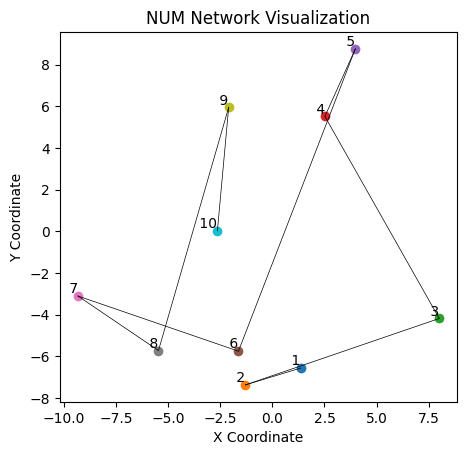


NUM network general params:
num of users= 10, network radius= 10, neighbors radius=2

USERS:
User(1) connect 1 to 10 through: 1-2 2-3 3-4 4-5 5-6 6-7 7-8 8-9 9-10 , and sends 1 flow with 480 data
User(2) connect 1 to 2 through: 1-2 , and sends 1 flow with 900 data
User(3) connect 2 to 3 through: 2-3 , and sends 1 flow with 932 data
User(4) connect 3 to 4 through: 3-4 , and sends 1 flow with 949 data
User(5) connect 4 to 5 through: 4-5 , and sends 1 flow with 702 data
User(6) connect 5 to 6 through: 5-6 , and sends 1 flow with 226 data
User(7) connect 6 to 7 through: 6-7 , and sends 1 flow with 622 data
User(8) connect 7 to 8 through: 7-8 , and sends 1 flow with 157 data
User(9) connect 8 to 9 through: 8-9 , and sends 1 flow with 901 data
User(10) connect 9 to 10 through: 9-10 , and sends 1 flow with 515 data

FLOWS:
1 send to 10 480
1 send to 2 900
2 send to 3 932
3 send to 4 949
4 send to 5 702
5 send to 6 226
6 send to 7 622
7 send to 8 157
8 send to 9 901
9 send to 10 515

--------

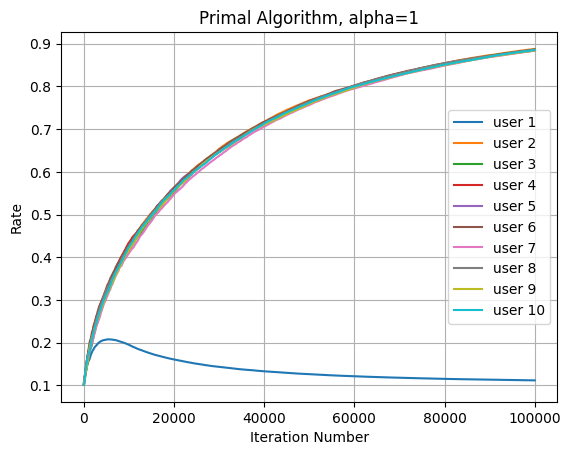

10


In [61]:
primal(1,10,10,2)


In [62]:
def dual(alpha,num_of_users=N, radius=M, neighbors_radius=R):
    #dual algorithm
    #N = 5
    Algo ="Dual"
    #alpha = 1
    set_global_params( n=num_of_users, m=radius, r=neighbors_radius, f=None)
    calc_inter_face = False
    network = Network(N,M,R,create_network_type="NUM")
    network.draw_network()
    print(network)
    CalcNetworkRate(network, alpha, Algo)
    plt.show()  # to stop the code so we can analyze the graph showing the rates


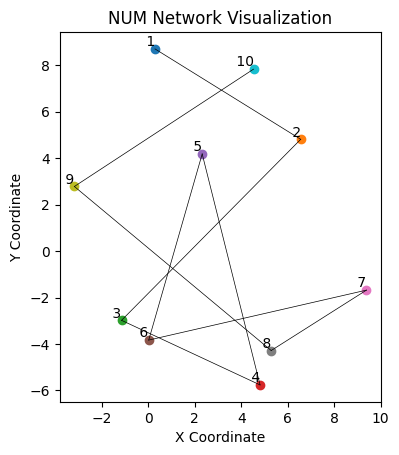


NUM network general params:
num of users= 10, network radius= 10, neighbors radius=2

USERS:
User(1) connect 1 to 10 through: 1-2 2-3 3-4 4-5 5-6 6-7 7-8 8-9 9-10 , and sends 1 flow with 287 data
User(2) connect 1 to 2 through: 1-2 , and sends 1 flow with 582 data
User(3) connect 2 to 3 through: 2-3 , and sends 1 flow with 127 data
User(4) connect 3 to 4 through: 3-4 , and sends 1 flow with 444 data
User(5) connect 4 to 5 through: 4-5 , and sends 1 flow with 913 data
User(6) connect 5 to 6 through: 5-6 , and sends 1 flow with 548 data
User(7) connect 6 to 7 through: 6-7 , and sends 1 flow with 871 data
User(8) connect 7 to 8 through: 7-8 , and sends 1 flow with 28 data
User(9) connect 8 to 9 through: 8-9 , and sends 1 flow with 554 data
User(10) connect 9 to 10 through: 9-10 , and sends 1 flow with 973 data

FLOWS:
1 send to 10 287
1 send to 2 582
2 send to 3 127
3 send to 4 444
4 send to 5 913
5 send to 6 548
6 send to 7 871
7 send to 8 28
8 send to 9 554
9 send to 10 973

----------

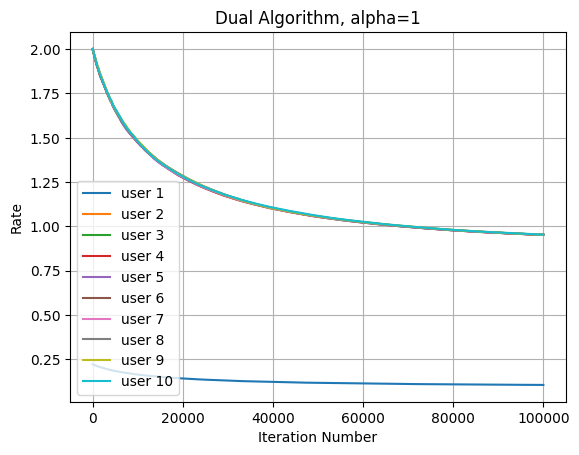

In [63]:
dual(1,10,10,2)

<h2>question 4- primal algoritem for a=[1,2,inf]

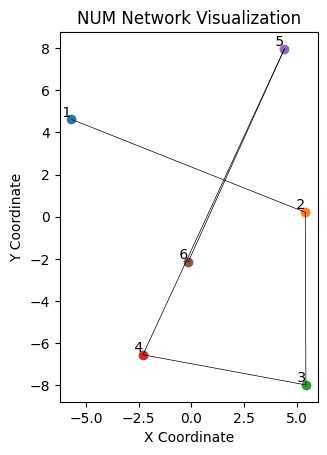


NUM network general params:
num of users= 6, network radius= 10, neighbors radius=5

USERS:
User(1) connect 1 to 6 through: 1-2 2-3 3-4 4-5 5-6 , and sends 1 flow with 726 data
User(2) connect 1 to 2 through: 1-2 , and sends 1 flow with 761 data
User(3) connect 2 to 3 through: 2-3 , and sends 1 flow with 998 data
User(4) connect 3 to 4 through: 3-4 , and sends 1 flow with 42 data
User(5) connect 4 to 5 through: 4-5 , and sends 1 flow with 21 data
User(6) connect 5 to 6 through: 5-6 , and sends 1 flow with 129 data

FLOWS:
1 send to 6 726
1 send to 2 761
2 send to 3 998
3 send to 4 42
4 send to 5 21
5 send to 6 129

-------------------------
Primal Algorithm, alpha=1 Results:
user 1 rate : 0.17
user 2 rate : 0.83
user 3 rate : 0.83
user 4 rate : 0.83
user 5 rate : 0.83
user 6 rate : 0.83
sum_rate=4.34



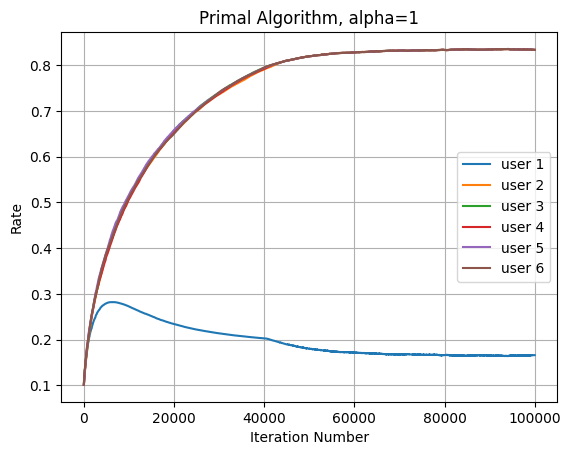

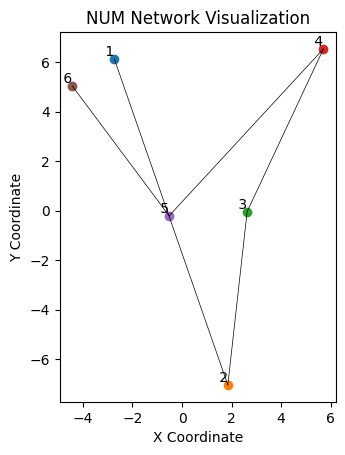


NUM network general params:
num of users= 6, network radius= 10, neighbors radius=5

USERS:
User(1) connect 1 to 6 through: 1-2 2-3 3-4 4-5 5-6 , and sends 1 flow with 880 data
User(2) connect 1 to 2 through: 1-2 , and sends 1 flow with 361 data
User(3) connect 2 to 3 through: 2-3 , and sends 1 flow with 821 data
User(4) connect 3 to 4 through: 3-4 , and sends 1 flow with 200 data
User(5) connect 4 to 5 through: 4-5 , and sends 1 flow with 515 data
User(6) connect 5 to 6 through: 5-6 , and sends 1 flow with 297 data

FLOWS:
1 send to 6 880
1 send to 2 361
2 send to 3 821
3 send to 4 200
4 send to 5 515
5 send to 6 297

-------------------------
Primal Algorithm, alpha=2 Results:
user 1 rate : -106.36
user 2 rate : 108.04
user 3 rate : 108.05
user 4 rate : 86.92
user 5 rate : 86.7
user 6 rate : 108.06
sum_rate=391.41



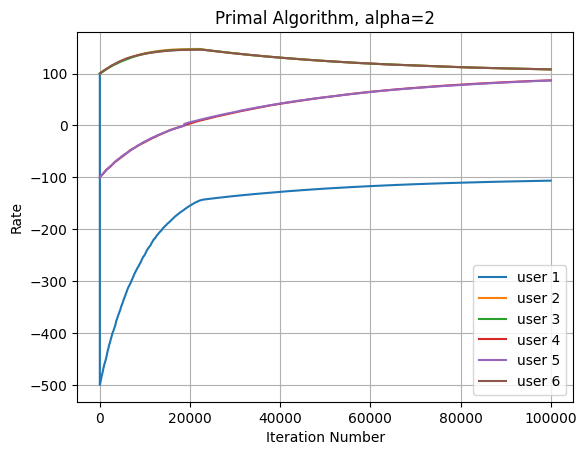

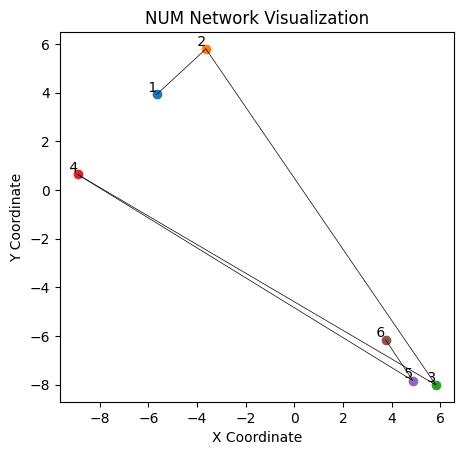


NUM network general params:
num of users= 6, network radius= 10, neighbors radius=5

USERS:
User(1) connect 1 to 6 through: 1-2 2-3 3-4 4-5 5-6 , and sends 1 flow with 962 data
User(2) connect 1 to 2 through: 1-2 , and sends 1 flow with 618 data
User(3) connect 2 to 3 through: 2-3 , and sends 1 flow with 38 data
User(4) connect 3 to 4 through: 3-4 , and sends 1 flow with 292 data
User(5) connect 4 to 5 through: 4-5 , and sends 1 flow with 210 data
User(6) connect 5 to 6 through: 5-6 , and sends 1 flow with 841 data

FLOWS:
1 send to 6 962
1 send to 2 618
2 send to 3 38
3 send to 4 292
4 send to 5 210
5 send to 6 841

-------------------------
Primal Algorithm, alpha=inf Results:
user 1 rate : 0.45
user 2 rate : 0.45
user 3 rate : 0.45
user 4 rate : 0.45
user 5 rate : 0.45
user 6 rate : 0.45
sum_rate=2.72



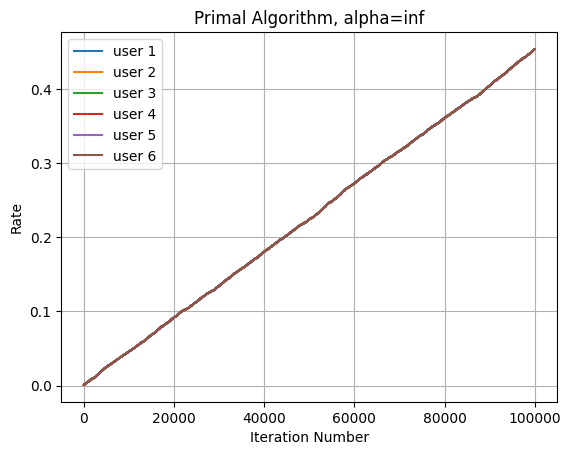

In [64]:
alpha=[1,2,float("inf")]
for a in alpha:
    primal(a,6,10,5)

<h2>question 4- dual algoritem for a=[1,2,inf]

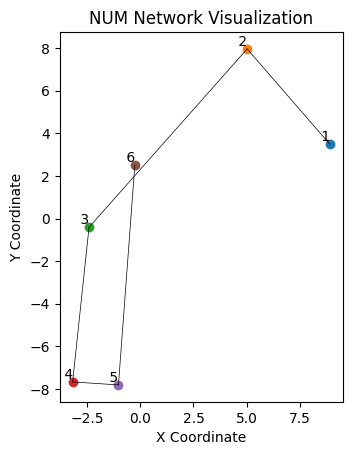


NUM network general params:
num of users= 6, network radius= 10, neighbors radius=2

USERS:
User(1) connect 1 to 6 through: 1-2 2-3 3-4 4-5 5-6 , and sends 1 flow with 849 data
User(2) connect 1 to 2 through: 1-2 , and sends 1 flow with 393 data
User(3) connect 2 to 3 through: 2-3 , and sends 1 flow with 494 data
User(4) connect 3 to 4 through: 3-4 , and sends 1 flow with 130 data
User(5) connect 4 to 5 through: 4-5 , and sends 1 flow with 960 data
User(6) connect 5 to 6 through: 5-6 , and sends 1 flow with 590 data

FLOWS:
1 send to 6 849
1 send to 2 393
2 send to 3 494
3 send to 4 130
4 send to 5 960
5 send to 6 590

-------------------------
Dual Algorithm, alpha=1 Results:
user 1 rate : 0.17
user 2 rate : 0.85
user 3 rate : 0.85
user 4 rate : 0.85
user 5 rate : 0.85
user 6 rate : 0.85
sum_rate=4.42



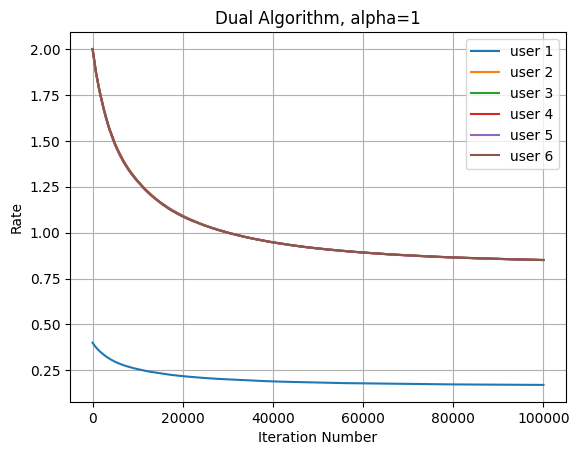

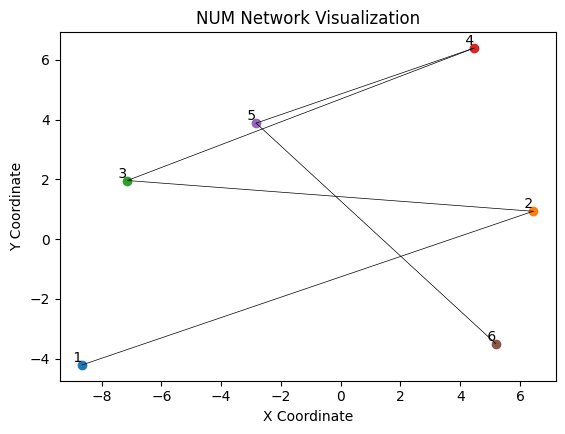


NUM network general params:
num of users= 6, network radius= 10, neighbors radius=2

USERS:
User(1) connect 1 to 6 through: 1-2 2-3 3-4 4-5 5-6 , and sends 1 flow with 320 data
User(2) connect 1 to 2 through: 1-2 , and sends 1 flow with 803 data
User(3) connect 2 to 3 through: 2-3 , and sends 1 flow with 938 data
User(4) connect 3 to 4 through: 3-4 , and sends 1 flow with 562 data
User(5) connect 4 to 5 through: 4-5 , and sends 1 flow with 414 data
User(6) connect 5 to 6 through: 5-6 , and sends 1 flow with 734 data

FLOWS:
1 send to 6 320
1 send to 2 803
2 send to 3 938
3 send to 4 562
4 send to 5 414
5 send to 6 734

-------------------------
Dual Algorithm, alpha=2 Results:
user 1 rate : 0.35
user 2 rate : 0.78
user 3 rate : 0.79
user 4 rate : 0.78
user 5 rate : 0.78
user 6 rate : 0.79
sum_rate=4.27



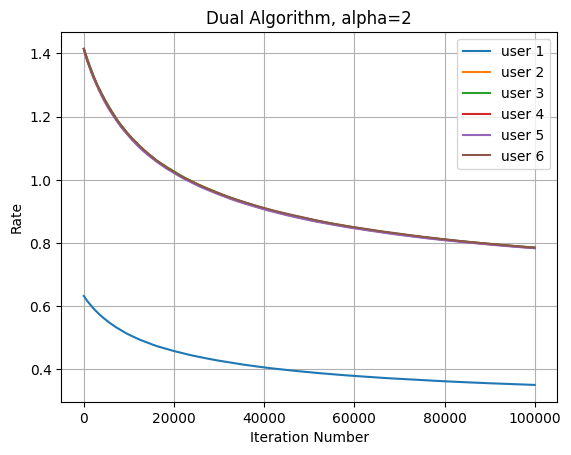

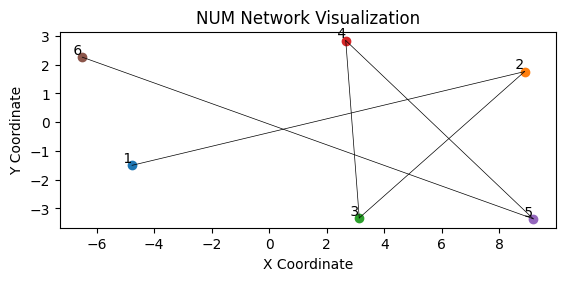


NUM network general params:
num of users= 6, network radius= 10, neighbors radius=2

USERS:
User(1) connect 1 to 6 through: 1-2 2-3 3-4 4-5 5-6 , and sends 1 flow with 65 data
User(2) connect 1 to 2 through: 1-2 , and sends 1 flow with 635 data
User(3) connect 2 to 3 through: 2-3 , and sends 1 flow with 149 data
User(4) connect 3 to 4 through: 3-4 , and sends 1 flow with 166 data
User(5) connect 4 to 5 through: 4-5 , and sends 1 flow with 499 data
User(6) connect 5 to 6 through: 5-6 , and sends 1 flow with 136 data

FLOWS:
1 send to 6 65
1 send to 2 635
2 send to 3 149
3 send to 4 166
4 send to 5 499
5 send to 6 136

-------------------------
Dual Algorithm, alpha=inf Results:
user 1 rate : 0.48
user 2 rate : 0.49
user 3 rate : 0.49
user 4 rate : 0.49
user 5 rate : 0.49
user 6 rate : 0.48
sum_rate=2.9



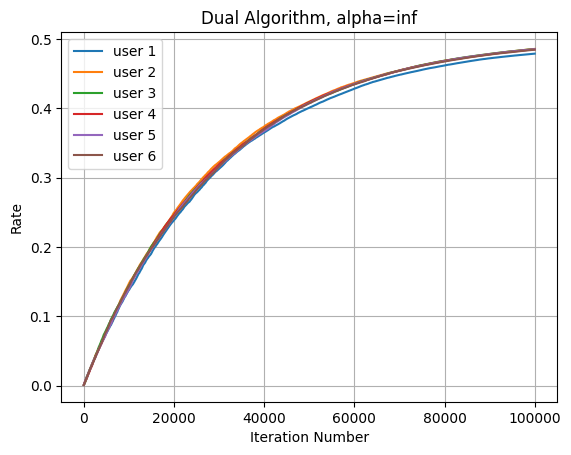

In [65]:
alpha=[1,2,float("inf")]
for a in alpha:
    dual(a,6,10,2)

<h2>question 5- primal algoritem with Dijkatra

In [66]:
def dijkastra_primal(alpha):
    N = 5  # num of users
    M = 10 # network radius
    R = 2  # neighbors radius

    Algo = 'Primal'
    
    calc_inter_face = False
    network = Network(N,M,R,create_network_type="NUM")
    network.draw_network()

    print(f'\nResult before Dijkstra\n')
    CalcNetworkRate(network, alpha, Algo)
    print(f'\nResult after Dijkstra\n')
    network.update_network_paths_using_Dijkstra()
    CalcNetworkRate(network, alpha, Algo)
    plt.show()

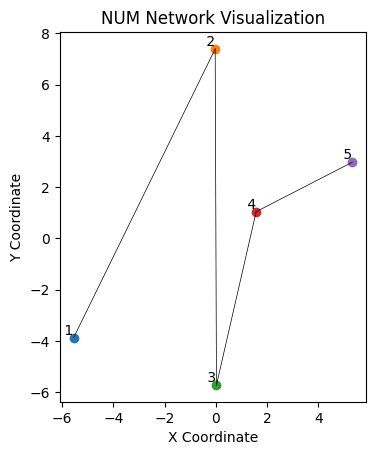


Result before Dijkstra

-------------------------
Primal Algorithm, alpha=1 Results:
user 1 rate : 0.2
user 2 rate : 0.8
user 3 rate : 0.8
user 4 rate : 0.8
user 5 rate : 0.8
sum_rate=3.4



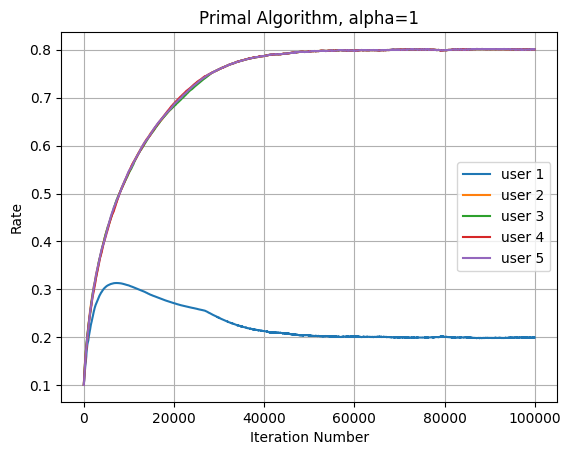


Result after Dijkstra

-------------------------
Primal Algorithm, alpha=1 Results:
user 1 rate : 0.2
user 2 rate : 0.8
user 3 rate : 0.8
user 4 rate : 0.8
user 5 rate : 0.8
sum_rate=3.4



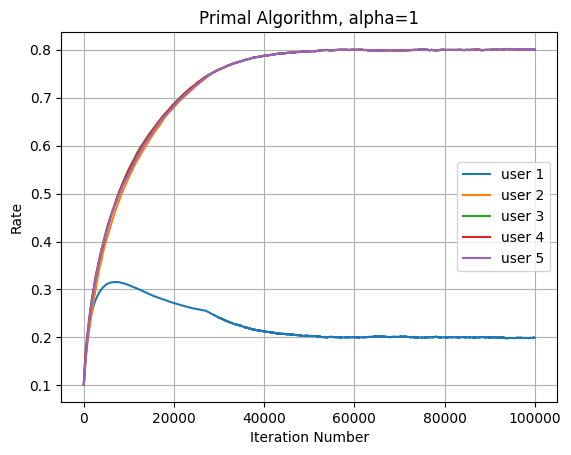

In [67]:
dijkastra_primal(1)

<h2>question 5- dual algoritem with dijkastra

In [68]:
def dijkastra_dual(alpha):
    N = 5  # num of users
    M = 10 # network radius
    R = 2  # neighbors radius

    Algo = 'Dual'
    
    calc_inter_face = False
    network = Network(N,M,R,create_network_type="NUM")
    network.draw_network()

    print(f'\nResult before Dijkstra\n')
    CalcNetworkRate(network, alpha, Algo)
    print(f'\nResult after Dijkstra\n')
    network.update_network_paths_using_Dijkstra()
    CalcNetworkRate(network, alpha, Algo)
    plt.show()

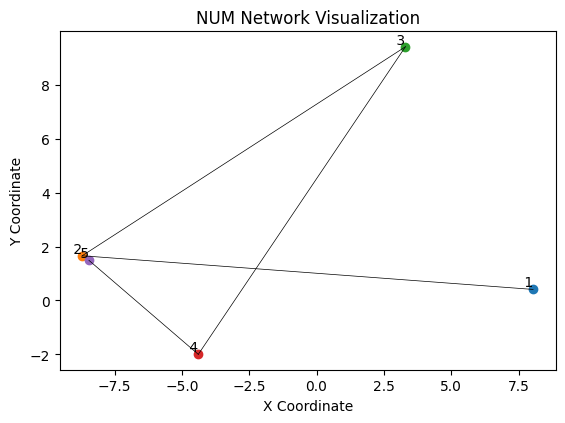


Result before Dijkstra

-------------------------
Dual Algorithm, alpha=1 Results:
user 1 rate : 0.2
user 2 rate : 0.81
user 3 rate : 0.81
user 4 rate : 0.81
user 5 rate : 0.81
sum_rate=3.45



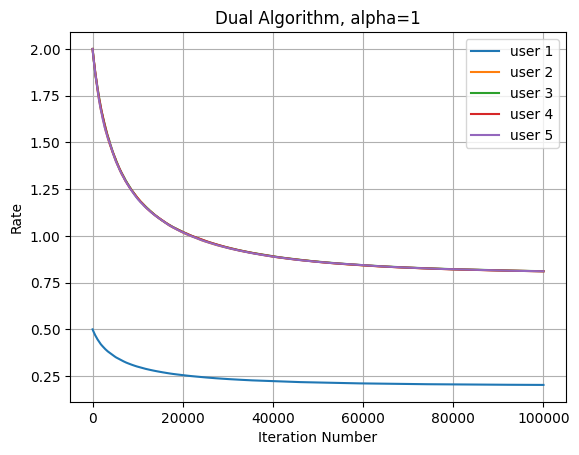


Result after Dijkstra

-------------------------
Dual Algorithm, alpha=1 Results:
user 1 rate : 0.2
user 2 rate : 0.8
user 3 rate : 0.8
user 4 rate : 0.8
user 5 rate : 0.8
sum_rate=3.4



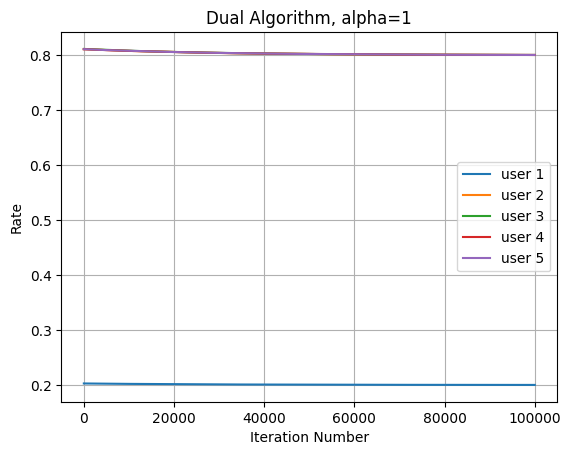

In [69]:
dijkastra_dual(1)

<h2>question 6- primal algoritem with bellman ford

In [70]:
def bellman_ford_Primal(alpha):
    N = 5  # num of users
    M = 10 # network radius
    R = 2  # neighbors radius

    Algo = 'Primal'
    
    calc_inter_face = False
    network = Network(N,M,R,create_network_type="NUM")
    network.draw_network()

    print(f'\nResult before bellman ford\n')
    CalcNetworkRate(network, alpha, Algo)
    print(f'\nResult after bellman ford\n')
    network.update_network_paths_using_bellman_ford()
    CalcNetworkRate(network, alpha, Algo)
    plt.show()

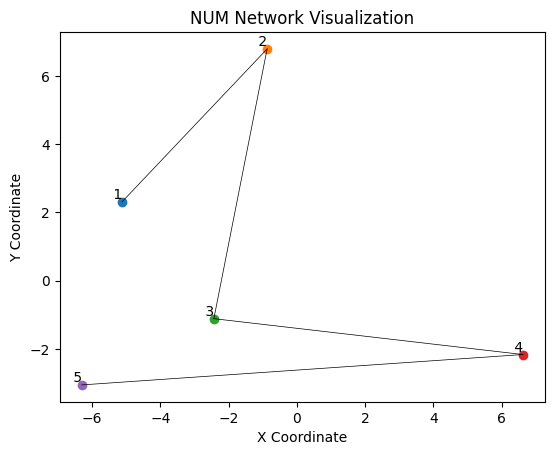


Result before bellman ford

-------------------------
Primal Algorithm, alpha=1 Results:
user 1 rate : 0.2
user 2 rate : 0.8
user 3 rate : 0.8
user 4 rate : 0.8
user 5 rate : 0.8
sum_rate=3.4



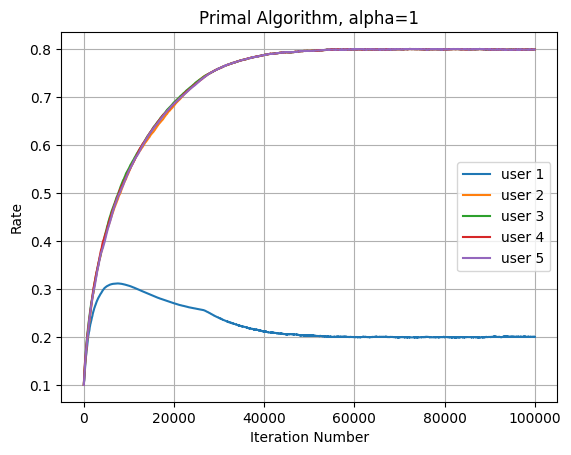


Result after bellman ford

-------------------------
Primal Algorithm, alpha=1 Results:
user 1 rate : 0.2
user 2 rate : 0.8
user 3 rate : 0.8
user 4 rate : 0.8
user 5 rate : 0.8
sum_rate=3.4



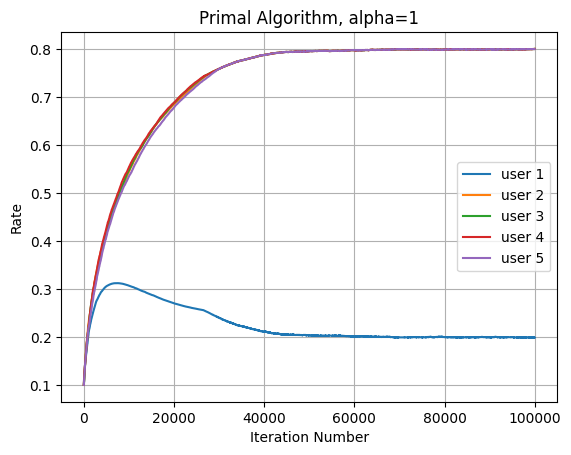

In [71]:
bellman_ford_Primal(1)

<h2>question 6- dual algoritem with bellman ford

In [72]:
def bellman_ford_dual(alpha):
    N = 5  # num of users
    M = 10 # network radius
    R = 2  # neighbors radius

    Algo = 'Dual'
    
    calc_inter_face = False
    network = Network(N,M,R,create_network_type="NUM")
    network.draw_network()

    print(f'\nResult before bellman ford\n')
    CalcNetworkRate(network, alpha, Algo)
    print(f'\nResult after bellman ford\n')
    network.update_network_paths_using_bellman_ford()
    CalcNetworkRate(network, alpha, Algo)
    plt.show()

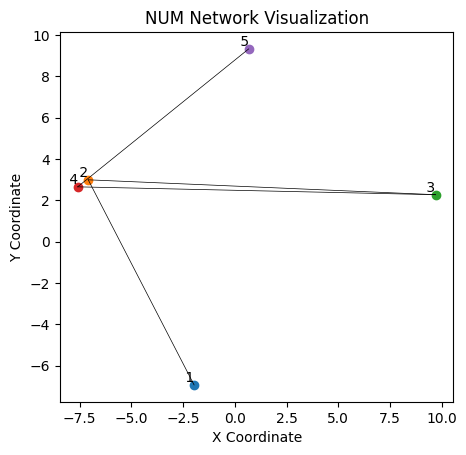


Result before bellman ford

-------------------------
Dual Algorithm, alpha=1 Results:
user 1 rate : 0.2
user 2 rate : 0.81
user 3 rate : 0.81
user 4 rate : 0.81
user 5 rate : 0.81
sum_rate=3.45



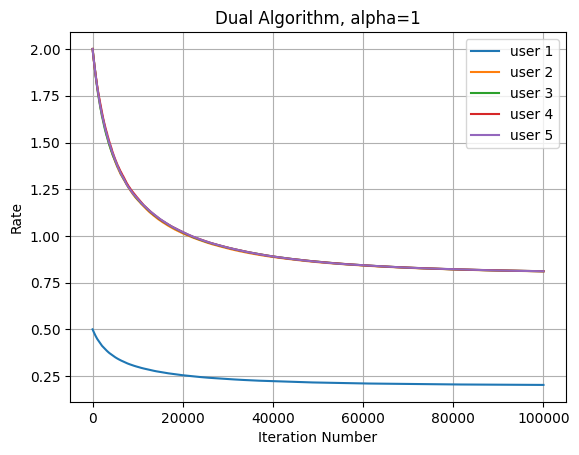


Result after bellman ford

-------------------------
Dual Algorithm, alpha=1 Results:
user 1 rate : 0.2
user 2 rate : 0.8
user 3 rate : 0.8
user 4 rate : 0.8
user 5 rate : 0.8
sum_rate=3.4



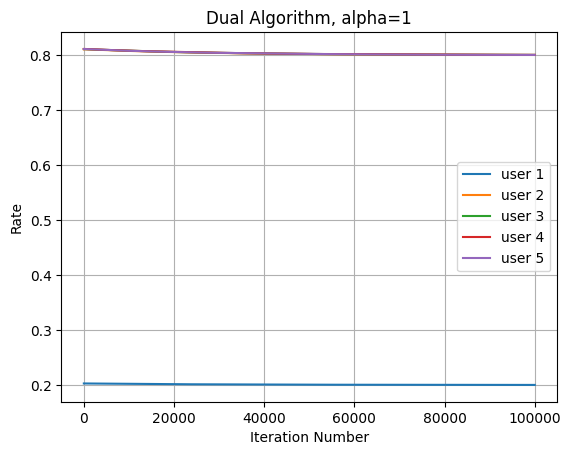

In [73]:
bellman_ford_dual(1)